In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import shared

In [2]:
import pymc3 as pm

## Stochastic / deterministic variables and model objects in PyMC3

### Model objects

In [3]:
# We create all of our variables within model objects

with pm.Model() as model: # everything created within context of model object belongs to model now
    lambda_param = pm.Exponential("poisson_param", 1.0) 
    DGP = pm.Poisson("DGP", lambda_param)

In [4]:
# We can look at our variables outside the model context, but they can be defined only inside it 

lambda_param

poisson_param

### Stochastic variables

How to define a stochastic variable: 
``python_var_name = pm.DiscreteUniform("pymc_var_name", 0, 10)``

Make the pymc_var_name descriptive because that's where the posterior distro will be later on!

In [5]:
with pm.Model() as another_model:
    lambda_param = pm.Exponential("poisson_param", 1.0)

In [6]:
# Each variable already has a test value
lambda_param.tag.test_value

# test_value is the starting point for sampling in the model if no other initial value is set. 
# It doesn't change the sampling. 

array(0.69314718)

### Deterministic variables

In [7]:
with pm.Model() as model:
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)

new_deterministic_variable = lambda_1 + lambda_2

In [8]:
def subtract(x, y):
    return x - y

with pm.Model() as model: 
    stochastic_1 = pm.Uniform("U_1", 0, 1)
    stochastic_2 = pm.Uniform("U_2", 0, 1)

    det_1 = pm.Deterministic("Delta", subtract(stochastic_1, stochastic_2))

### Putting it all together and looking at our distribution

In [9]:
with pm.Model() as model: 
    lambda_param = pm.Exponential("poisson_param", 1.0) 
    DGP = pm.Poisson("DGP", lambda_param)

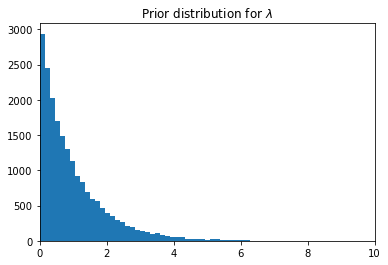

In [11]:
samples = lambda_param.random(size=20000) # this is the stochastic variable we just defined above 

# plot the samples from the exponential distribution
plt.hist(samples, bins=60,  histtype="stepfilled")
plt.title("Prior distribution for $\lambda$")
plt.xlim(0, 10);

## Fitting a distribution to data

### Telling PyMC3 about our observed data

In [12]:
my_fake_data = np.array([34, 54, 81, 23, 94]) # e.g. number of visitors to our website per day 

with pm.Model() as model:
    fixed_variable = pm.Poisson("fixed_var", 1, observed=my_fake_data)
    
print("Value of fixed variable: ", fixed_variable.tag.test_value)

Value of fixed variable:  [34 54 81 23 94]


### Priors far from true data, expansive priors

Let's sample some random data from a Normal distribution N(mu=0,sd=.5) and try to fit a distro to it using PyMC3. We're trying to see if PyMC3 can use the samples to guess the parameters of our distribution. 

In [13]:
normal_sample = np.random.normal(0, 1.0, 1000) # mu = 0, sd = 1.0, num. samples = 1000

In [14]:
# Fit a Normal distro to our data and see if we can recover our parameters 

with pm.Model() as random_normal:

    # set our priors for the parameters (stochastic nodes)
    sd = pm.HalfNormal('sd', sd=.5) # SD won't be zero so use half Normal
    mu = pm.Normal('mu', mu=2.0, sd=1.0)

    pred = pm.Normal('pred', mu=mu, sd=sd, observed=normal_sample)

In [15]:
print("Type of mu:" , type(mu))
print("\nMean: ", mu.distribution.mean.eval())
print("\nLogp at .5: " , mu.distribution.logp(.5).eval()) # log means we can add probabilities instead of multiplying

Type of mu: <class 'pymc3.model.FreeRV'>

Mean:  2.0

Logp at .5:  -2.0439385332046727


In [16]:
with random_normal:
    trace_normal = pm.sample(500) # MCMC, can use other algos ; sample = # of draws 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sd]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████████| 4000/4000 [00:03<00:00, 1062.00draws/s]
The acceptance probability does not match the target. It is 0.9085009808615334, but should be close to 0.8. Try to increase the number of tuning steps.


C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


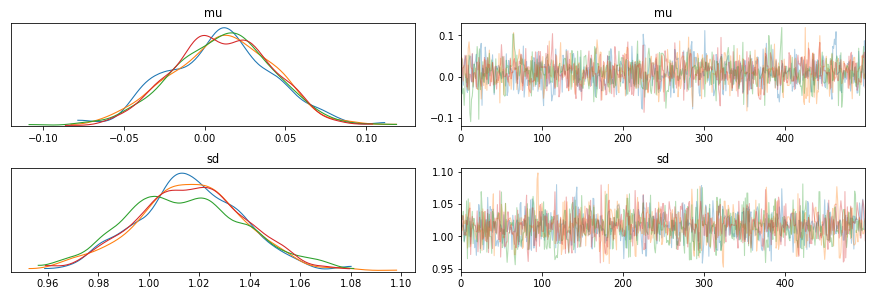

In [17]:
pm.traceplot(trace_normal, ['mu', 'sd']);

### Priors far from true data, restrictive priors 

In [18]:
normal_sample = np.random.normal(0, 1.0, 1000) # mu = 0, sd = 1.0, num. samples = 1000

In [19]:
# Fit a Normal distro to our data and see if we can recover our parameters 
# This time with restrictive priors far away from the true values

with pm.Model() as random_normal:

    sd = pm.HalfNormal('sd', sd=.1) 
    mu = pm.Normal('mu', mu=2.0, sd=.1)

    pred = pm.Normal('pred', mu=mu, sd=sd, observed=normal_sample)

In [20]:
with random_normal:
    trace_normal = pm.sample(500) # MCMC, can use other algos ; sample = # of draws 
                                   # Will use NUTS (no u-turn sampler), which says we don't have to set # steps 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sd]
Sampling 4 chains, 0 divergences: 100%|████████████████████████████████████████| 4000/4000 [00:12<00:00, 329.30draws/s]
The acceptance probability does not match the target. It is 0.8986019685015866, but should be close to 0.8. Try to increase the number of tuning steps.


C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


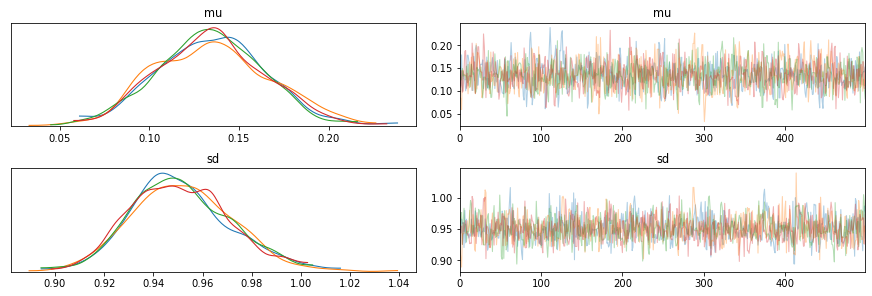

In [21]:
pm.traceplot(trace_normal, ['mu', 'sd']);

## Linear Regression 

In [22]:
# Let's generate some fake (X,Y) data to fit a linear model

def make_random_OLS_data(num_obs, intercept, beta): 
    X = np.random.normal(1.0, 0.1, num_obs)
    epsilon = np.random.normal(0.0, 0.1, num_obs) # random noise 
    
    # Define our DGP
    y = intercept + (beta*X) + epsilon
    return X, y

In [23]:
X_train, y_train = make_random_OLS_data(num_obs=1000,intercept=1.5,beta=.25)

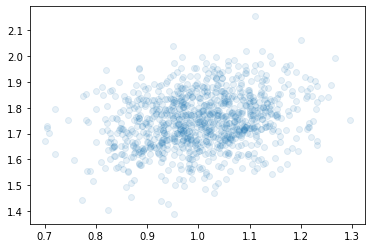

In [24]:
plt.scatter(X_train, y_train, alpha=.1)

In [25]:
with pm.Model() as OLS:

    # Set the priors on the parameters of OLS 
    intercept = pm.Normal('intercept', mu=0.75, sd=1.) # actual = 1.5
    beta = pm.Normal('beta', mu=0.0, sd=1.) # actual = .25
    mu = (beta*X_train) + intercept
    sd = pm.HalfNormal('sd', sd=.1)
    
    y = pm.Normal('y_est', mu=mu, sd=sd, observed=y_train)

In [26]:
with OLS:
    trace = pm.sample(2500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, beta, intercept]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████████| 12000/12000 [00:18<00:00, 643.90draws/s]
The acceptance probability does not match the target. It is 0.886693209752226, but should be close to 0.8. Try to increase the number of tuning steps.


C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


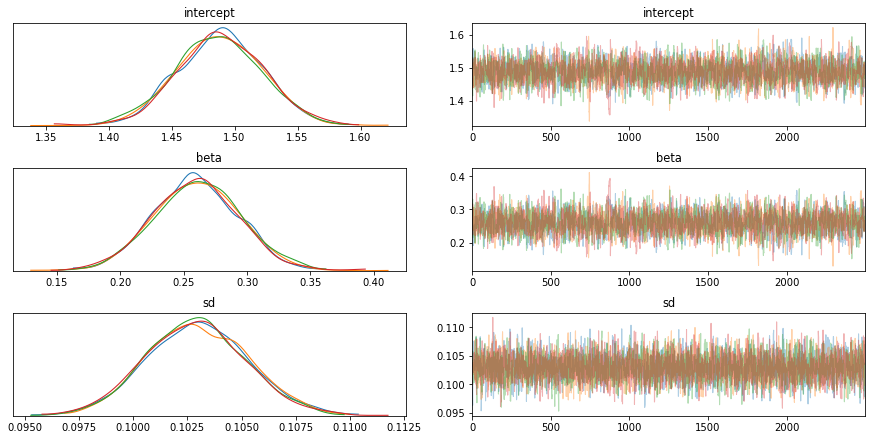

In [27]:
pm.traceplot(trace, ['intercept', 'beta', 'sd']); 
# intercept: true = 1.5 | prior = .75
# beta: true = .25 | prior = 0.
# true sd = .1

**ppc = posterior predictive check**

In [28]:
# ppc = posterior predictive check 
# Gelman: "simulating replicated data under the fitted model and then comparing these to the observed data"
# Use posterior predictive checks to "look for systematic discrepancies between real and simulated data"

with OLS:
    
    # sample the posterior to fit
    ppc = pm.sample_ppc(trace, samples=2000) 

print("\nCreate 2000 samples per each of our 1000 observation:", ppc['y_est'].shape)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
C:\Anaconda3\lib\site-packages\pymc3\sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 710.79it/s]


Create 2000 samples per each of our 1000 observation: (2000, 1000)


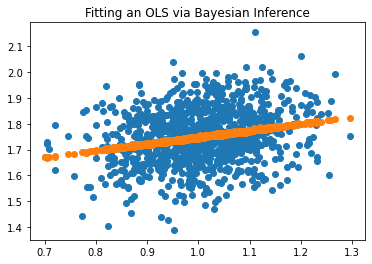

In [29]:
# Use the mean of the 2000 samples per observation to fit our OLS  
y_hat = ppc['y_est']
y_hat_mean = np.reshape(np.mean(y_hat, axis=0), [-1])

plt.scatter(X_train, y_train)
plt.scatter(X_train, y_hat_mean)
plt.title("Fitting an OLS via Bayesian Inference");

## Hierarchical Linear Model

In [30]:
# generate random data 

NUM_GROUPS = 10; 

def generate_hierarchical_data(num_obs_per_group, num_groups, pop_intercept, pop_beta, pop_sd):
    
    group_lvl_params = []
    # numpy arrays most efficient when you create empty ones of the size you'll need at the start
    # since they're assigned contiguous memory 
    Y = np.zeros(shape=(num_groups*num_obs_per_group,1))
    X = np.zeros(shape=(num_groups*num_obs_per_group,1))
    group_id = np.zeros(shape=(num_groups*num_obs_per_group,1))

    for _ in range(num_groups):
        intercept_grp = np.random.normal(pop_intercept, pop_sd)
        beta_grp = np.random.normal(pop_beta, pop_sd)
        group_lvl_params.append([intercept_grp, beta_grp])
        
    print("Group level parameters: \n" , group_lvl_params)
        
    for i, group in enumerate(group_lvl_params):
        indiv_epsilon = np.reshape(np.random.normal(0.0, 0.01, num_obs_per_group), [-1, 1])
        y = group[1]*indiv_epsilon + group[0] # use group parameters and noise (epsilon) to create individual obs

        X[i*num_obs_per_group:i*num_obs_per_group+num_obs_per_group,0] = indiv_epsilon.ravel()
        group_id[i*num_obs_per_group:i*num_obs_per_group+num_obs_per_group,0] = np.ones_like(indiv_epsilon).ravel() * i
        Y[i*num_obs_per_group:i*num_obs_per_group+num_obs_per_group,0] = y.ravel()
    
    return X, Y, group_id

def RMSE(Y,y_hat): 
    return np.sqrt(np.mean((y_hat - Y) ** 2.0))

X, Y, group_id = generate_hierarchical_data(num_obs_per_group=50,num_groups=NUM_GROUPS,pop_intercept=2.3,
                                  pop_beta=4.5,pop_sd=.1)

Group level parameters: 
 [[2.1366954630628157, 4.557650192739706], [2.36657336811365, 4.670836485746085], [2.142994388938437, 4.50255250772806], [2.1513501875972874, 4.568033871860516], [2.3732846827252745, 4.496378372004515], [2.05941002310775, 4.486034406026749], [2.5202959711767075, 4.45850742250093], [2.42327270756461, 4.382400173289009], [2.549785793625485, 4.468590363063621], [2.2807581483179233, 4.449308150318176]]


In [31]:
X_shared = shared(X) # from Theano, keeps data in memory 
Y_shared = shared(Y)

### Unpooled

In [32]:
with pm.Model() as FE_unpooled:

    intercept = pm.Normal('intercept', mu=1, sd=.5, shape=NUM_GROUPS)
    beta = pm.Normal('beta', mu=2, sd=.5, shape=NUM_GROUPS)
    mu = (beta[group_id.astype(int)] * X_shared) + intercept[group_id.astype(int)]
    
    y = pm.Normal('y', mu, observed=Y)

In [33]:
with FE_unpooled:
    unpooled_trace = pm.sample(2000, tune=500) # tune will use steps but discrad them 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████████| 10000/10000 [00:11<00:00, 888.73draws/s]


C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


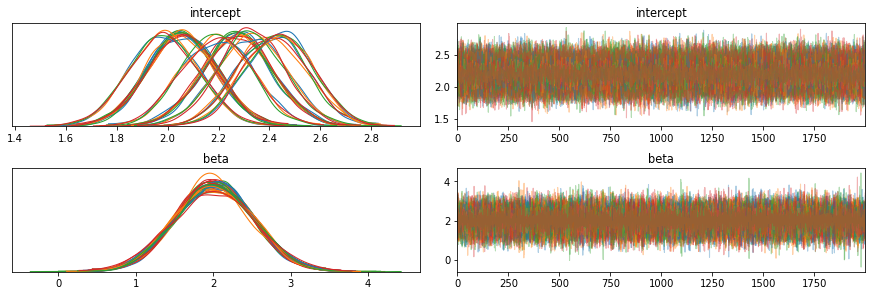

In [34]:
pm.traceplot(unpooled_trace, ['intercept', 'beta']);

In [35]:
#### RMSE of unpooled 
unpooled_sample = pm.sample_ppc(unpooled_trace, model=FE_unpooled, size=1000)
y_hat_unpooled = np.mean(unpooled_sample['y'], axis=1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [04:43<00:00, 28.20it/s]


In [36]:
unpooled_RMSE = RMSE(Y,y_hat_unpooled)

print("RMSE of unpooled: ", unpooled_RMSE)

RMSE of unpooled:  0.17107497423603124


### Hierarchical

In [37]:
with pm.Model() as RE_pooled:

    pop_intercept = pm.Normal('group_intercept', 1, sd=5., shape=1)
    pop_intercept_sigma = pm.HalfNormal('group_intercept_sigma', sd=.5)
    pop_beta = pm.Normal('group_beta', 4, sd=5., shape=1)
    pop_beta_sigma = pm.HalfNormal('group_beta_sigma', sd=.5)
    
    intercept = pm.Normal('intercept', mu=pop_intercept, sd=pop_intercept_sigma, shape=NUM_GROUPS)
    beta = pm.Normal('beta', mu=pop_beta, sd=pop_beta_sigma, shape=NUM_GROUPS)
    mu = (beta[group_id.astype(int)] * X_shared) + intercept[group_id.astype(int)]
    
    y = pm.Normal('y', mu, observed=Y_shared)

In [38]:
with RE_pooled:
    pooled_trace = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, intercept, group_beta_sigma, group_beta, group_intercept_sigma, group_intercept]
Sampling 4 chains, 2,020 divergences: 100%|██████████████████████████████████| 16000/16000 [02:08<00:00, 124.35draws/s]
There were 628 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5547301596987594, but should be close to 0.8. Try to increase the number of tuning steps.
There were 672 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.520892038775972, but should be close to 0.8. Try to increase the number of tuning steps.
There were 426 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6515750007472099, but should be close to 0.8. T

C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


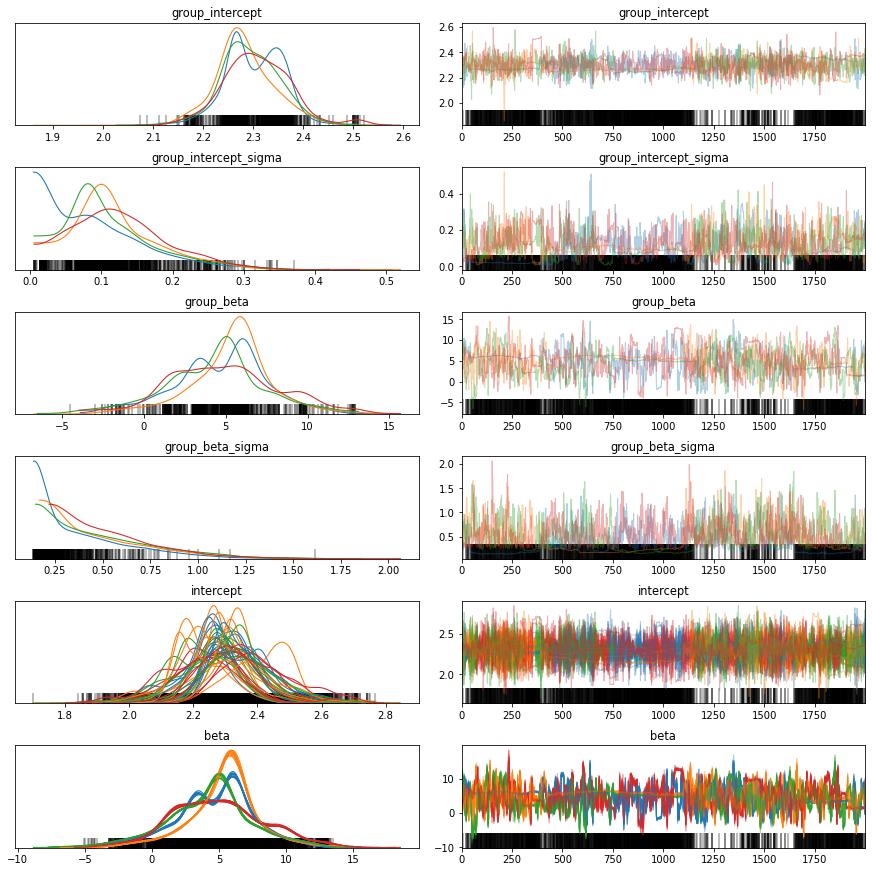

In [39]:
pm.traceplot(pooled_trace, ['group_intercept', 'group_intercept_sigma',
                     'group_beta', 'group_beta_sigma', 'intercept', 'beta']);

In [44]:
#### RMSE of pooled 
pooled_sample = pm.sample_ppc(pooled_trace, model=RE_pooled, size=500)
y_hat_pooled = np.mean(pooled_sample['y'], axis=1)

pooled_RMSE = RMSE(Y,y_hat_pooled)

print("RMSE of unpooled: ", unpooled_RMSE)
print("RMSE of pooled: ", pooled_RMSE)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [04:21<00:00, 30.54it/s]


RMSE of unpooled:  0.17107497423603124
RMSE of pooled:  0.1844166881130197
